In [ ]:
import requests
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import os

# -------- CONFIG --------
ERDDAP_BASE = "https://erddap.aoml.noaa.gov/gdp/erddap/tabledap"
DATASET = "drifter_6hour_qc"   # or "drifter_6hour_qc" if you want lighter files

# North Pacific bounds
LAT_MIN, LAT_MAX = 0, 70
LON360_MIN, LON360_MAX = 100, 270

# Time range
START = datetime(2010, 1, 1)
END   = datetime(2019, 12, 31)

# Variables you want
VARS = ["ID","time","latitude","longitude","lon360","ve","vn","sst"]

# Folder to save monthly files
OUTDIR = "drifter_monthly_6hour"
os.makedirs(OUTDIR, exist_ok=True)
# ------------------------

# Helper: month ranges
def month_range(start, end):
    current = start.replace(day=1)
    while current <= end:
        if current.month == 12:
            nxt = current.replace(year=current.year+1, month=1, day=1)
        else:
            nxt = current.replace(month=current.month+1, day=1)
        yield current, min(nxt - timedelta(seconds=1), end)
        current = nxt

for t0, t1 in month_range(START, END):
    T0 = t0.strftime("%Y-%m-%dT%H:%M:%SZ")
    T1 = t1.strftime("%Y-%m-%dT%H:%M:%SZ")
    cols = ",".join(VARS)
    constraints = [
        f"time>={T0}",
        f"time<={T1}",
        f"latitude>={LAT_MIN}",
        f"latitude<={LAT_MAX}",
        f"lon360>={LON360_MIN}",
        f"lon360<={LON360_MAX}"
    ]
    url = f"{ERDDAP_BASE}/{DATASET}.csv?{cols}&" + "&".join(constraints)
    fname = os.path.join(OUTDIR, f"drifters_6hour_{t0.strftime('%Y_%m')}.csv")

    if os.path.exists(fname):  # skip if already downloaded
        print("Skipping (already exists):", fname)
        continue

    print("Fetching:", T0, "to", T1)
    try:
        r = requests.get(url, timeout=180)
        r.raise_for_status()

        if r.text.strip() == "" or r.text.startswith("Error"):
            print("Empty or error for", T0)
        else:
            # Read all rows
            df = pd.read_csv(StringIO(r.text))

            # Drop the second row (index 0 is the first row, so index 1 is the second)
            df = df.drop(index=0).reset_index(drop=True)

            # Save cleaned DataFrame
            df.to_csv(fname, index=False)

            print("Saved:", fname, "with", len(df), "rows")

    except Exception as e:
        print("Failed:", e)

print("✅ Done. Monthly files saved in:", OUTDIR)

Fetching: 2010-01-01T00:00:00Z to 2010-01-31T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_01.csv with 38032 rows
Fetching: 2010-02-01T00:00:00Z to 2010-02-28T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_02.csv with 34881 rows
Fetching: 2010-03-01T00:00:00Z to 2010-03-31T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_03.csv with 38468 rows
Fetching: 2010-04-01T00:00:00Z to 2010-04-30T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_04.csv with 36684 rows
Fetching: 2010-05-01T00:00:00Z to 2010-05-31T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_05.csv with 39994 rows
Fetching: 2010-06-01T00:00:00Z to 2010-06-30T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_06.csv with 40314 rows
Fetching: 2010-07-01T00:00:00Z to 2010-07-31T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_07.csv with 40919 rows
Fetching: 2010-08-01T00:00:00Z to 2010-08-31T23:59:59Z
Saved: drifter_monthly_6hour/drifters_6hour_2010_08.csv 

In [ ]:
import pandas as pd
import os

# Folder where you saved monthly files
OUTDIR = "drifter_monthly_6hour"

# Collect all monthly CSVs
files = sorted([os.path.join(OUTDIR, f) 
                for f in os.listdir(OUTDIR) if f.endswith(".csv")])

print(f"Found {len(files)} monthly files")

# Load and concatenate
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print("Final dataframe shape:", df.shape)
print(df.head())

# Save as one big CSV
df.to_csv("north_pacific_drifters_6hour_2010_2019.csv", index=False)
print("Saved combined file: north_pacific_drifters_6hour_2010_2019.csv")

Found 120 monthly files
Final dataframe shape: (4495317, 8)
          ID                  time  latitude  longitude   lon360       ve  \
0  2885151.0  2010-01-01T00:00:00Z    37.198    130.500  130.500  0.19994   
1  2885151.0  2010-01-01T06:00:00Z    37.175    130.551  130.551  0.44422   
2  2885151.0  2010-01-01T12:00:00Z    37.201    130.716  130.716  0.72457   
3  2885151.0  2010-01-01T18:00:00Z    37.199    130.904  130.904  0.74290   
4  2885151.0  2010-01-02T00:00:00Z    37.208    131.078  131.078  0.64879   

        vn     sst  
0 -0.24432  10.875  
1  0.00921  10.546  
2  0.06324  10.762  
3  0.01781  11.124  
4  0.02115  11.108  
Saved combined file: north_pacific_drifters_6hour_2010_2019.csv


# Filter the buoys to be in the region

In [23]:
import pandas as pd 
import geopandas as gpd


df = pd.read_csv("north_pacific_drifters_6hour_2010_2019.csv")
region = gpd.read_file("region.gpkg")

# Filter the buoys to be in the region

# mask = gdf.within(poly)     # poly from step 4
# df_in_np = df[mask]

In [28]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

In [27]:
poly = region.union_all()

In [29]:
mask = gdf.within(poly)
df_in_region = df[mask]

In [ ]:
df_in_region.to_csv("north_pacific_drifters_6hour_2010_2019-in_region.csv", index=False)

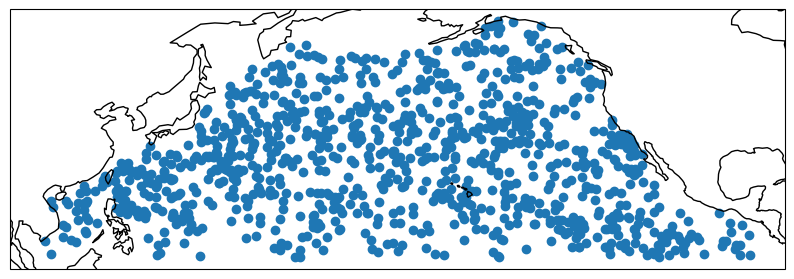

In [42]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs


# Set up Cartopy plot
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(10, 6))
ax.coastlines()


# Plot polygons from geopandas
ax.scatter(*df_in_region.sample(1000)[['longitude', 'latitude']].values.T, transform=ccrs.PlateCarree())

# Pick the 1500 farthest apart buoys

In [48]:
import numpy as np
import gudhi as gd
from collections import Counter


def get_data_indices(datasubset, fulldata):
    npoint = datasubset.shape[0]
    output = np.ones(npoint)
    for i in range(npoint):
        b = Counter(np.where((fulldata == datasubset[i,:] ))[0])
        output[i] = (b.most_common(1)[0][0])
    output = np.asarray(output,dtype = int)
    return output


def choose_n_farthest_points(points, nb_points, seed=None):
    rdn_state = np.random if seed is None else np.random.RandomState(seed=seed)
    starting_point = rdn_state.choice(points.shape[0])
    out_points = np.array(gd.choose_n_farthest_points(
        points=points, nb_points=nb_points, starting_point=starting_point))
    return get_data_indices(out_points, points)


In [45]:
import pandas as pd
import numpy as np
from pyproj import Transformer

df = pd.read_csv("north_pacific_drifters_6hour_2010_2019-in_region.csv", usecols=['longitude', 'latitude'])
transformer = Transformer.from_crs("EPSG:4326", "EPSG:4978", always_xy=True)
lons, lats = df['longitude'].values, df['latitude'].values

del df

In [46]:
heights = np.zeros(len(lons))
x, y, z = transformer.transform(lons, lats, heights)

In [49]:
res = choose_n_farthest_points(np.c_[x, y, z], 1500)

In [50]:
x_buoys, y_buoys, z_buoys = x[res], y[res], z[res]
df_buoys = pd.DataFrame({'x': x_buoys, 'y': y_buoys, 'z': z_buoys})
df_buoys.to_csv("buoys.csv", index=False)

# Create Vietoris-Rips

In [1]:
import pandas as pd 
from pyproj import Transformer
df_buoys = pd.read_csv("buoys.csv")


to_geo = Transformer.from_crs("EPSG:4978", "EPSG:4326", always_xy=True)
lons_buoys, lats_buoys, heights_buoys = to_geo.transform(*df_buoys.values.T)
df_buoys_lonlat = pd.DataFrame({'longitude': lons_buoys, 'latitude': lats_buoys})

In [2]:
# Author: Yu-Chia Chen <yuchaz@uw.edu>
# LICENSE: Simplified BSD https://github.com/yuchaz/homology_emb/blob/main/LICENSE

from __future__ import division, print_function, absolute_import
from scipy.spatial.distance import squareform, pdist
import numpy as np
from itertools import combinations
import gudhi as gd
from tqdm.auto import tqdm


class SimplicialComplexDim2(object):
    def __init__(self, distance_matrix, delta=None):
        self.distance_matrix = distance_matrix
        self.delta_default = delta
        self.fitted = False

    def get_n1(self, delta=None):
        delta = self._get_delta(delta)
        return np.sum(squareform(self.distance_matrix) < delta)

    def _get_delta(self, delta):
        if self.delta_default is None and delta is None:
            raise ValueError('You must provide delta to call this function')
        elif delta is None:
            delta = self.delta_default
        return delta

    def fit(self, delta=None, no_triangle=False):
        delta = self._get_delta(delta)
        vr_func = (compute_vr_edges_triangles if not no_triangle else
                   compute_vr_edges_no_triangles)
        self.nodes, self.edges, self.triangles = vr_func(
            self.distance_matrix, delta
        )
        self.edge_distance = np.array([
            self.distance_matrix[s, t] for s, t in self.edges
        ])
        self.fitted = True


def compute_vr_edges_triangles(distance_matrix, delta):
    vr_complex = gd.RipsComplex(distance_matrix=distance_matrix,
                                max_edge_length=delta)
    vr_spx_tree = vr_complex.create_simplex_tree(max_dimension=2)
    nodes_ = list(vr_spx_tree.get_skeleton(0))
    edges_ = list(vr_spx_tree.get_skeleton(1))
    triangles_ = list(vr_spx_tree.get_skeleton(2))
    nodes = np.array([v[0] for v in nodes_])
    edges_np = np.array([v[0] for v in edges_ if len(v[0]) == 2])
    edges_alpha = np.array([v[1] for v in edges_ if len(v[0]) == 2])

    triangles_np = np.array([v[0] for v in triangles_ if len(v[0]) == 3])
    triangles_alpha = np.array([v[1] for v in triangles_ if len(v[0]) == 3])
    del triangles_
    triangles = np.array([
        tri for tri, alpha in zip(triangles_np, triangles_alpha)
        if alpha < delta
    ])
    edges = np.array([
        edge for edge, alpha in zip(edges_np, edges_alpha) if alpha < delta
    ])
    return nodes, edges, triangles


def compute_vr_edges_no_triangles(distance_matrix, delta):
    n0 = distance_matrix.shape[0]
    nodes = np.arange(n0)
    n1_max = int(n0 * (n0 - 1) / 2)
    edges = [(i, j) for i, j in combinations(nodes, 2)
             if distance_matrix[i, j] < delta]
    return nodes, np.array(edges), np.array([])


def cknn_distance(distance_matrix, k):
    kth_dist = np.array([dist_i[np.argpartition(dist_i, k)[k]]
                         for dist_i in distance_matrix])
    rho_x_rho_y = np.sqrt(np.outer(kth_dist, kth_dist))
    return distance_matrix / rho_x_rho_y


In [3]:
from pyproj import Transformer
from sklearn.metrics.pairwise import haversine_distances


def haversine(x):
    return haversine_distances(np.deg2rad(x))


x_buoys, y_buoys, z_buoys = df_buoys['x'].values, df_buoys['y'].values, df_buoys['z'].values
to_geo = Transformer.from_crs("EPSG:4978", "EPSG:4326", always_xy=True)
lons_buoys, lats_buoys, heights_buoys = to_geo.transform(x_buoys, y_buoys, z_buoys)
df_buoys_lonlat = pd.DataFrame({'longitude': lons_buoys, 'latitude': lats_buoys})

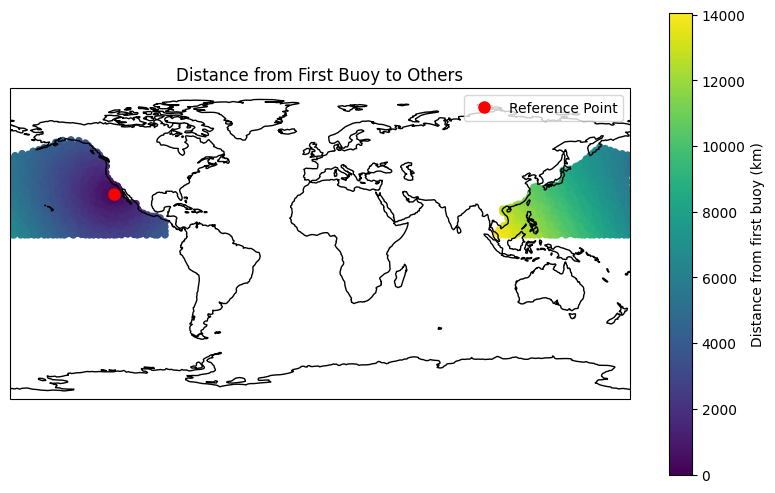

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Get the first point
lon0, lat0 = df_buoys_lonlat.iloc[0][['longitude', 'latitude']].values

# Get all other points
lons = df_buoys_lonlat['longitude'].values
lats = df_buoys_lonlat['latitude'].values

# Compute haversine distances (in radians, so multiply by Earth's radius to get km)
earth_radius_km = 6371.0
from sklearn.metrics.pairwise import haversine_distances
distances_rad = haversine_distances([[np.deg2rad(lat0), np.deg2rad(lon0)]], np.column_stack([np.deg2rad(lats), np.deg2rad(lons)]))[0]
distances_km = distances_rad * earth_radius_km

# Plot using Cartopy
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

# Scatter plot, color by distance
sc = ax.scatter(lons, lats, c=distances_km, cmap='viridis', s=20, transform=ccrs.PlateCarree())
ax.plot(lon0, lat0, 'ro', markersize=8, transform=ccrs.PlateCarree(), label='Reference Point')

plt.colorbar(sc, ax=ax, label='Distance from first buoy (km)')
plt.title('Distance from First Buoy to Others')
plt.legend()
plt.show()


In [4]:
# distance_matrix = squareform(pdist(df_buoys_lonlat[['latitude', 'longitude']].values))
distance_matrix = haversine(df_buoys_lonlat[['latitude', 'longitude']].values)

distance_matrix = cknn_distance(distance_matrix, 10)
sc2 = SimplicialComplexDim2(distance_matrix)

dmin = distance_matrix.min()
dmax = distance_matrix.max()
t = 0.981
delta = t * dmin + (1 - t) * dmax

In [5]:
sc2 = SimplicialComplexDim2(distance_matrix)
sc2.fit(delta, no_triangle=False)
sc2.edges.shape, sc2.triangles.shape

((4661, 2), (3557, 3))

In [6]:
def binary_search(objective, tol=1e-10, max_iter=50, lo=0.9, hi=1.0):
    """
    Binary search in [0.8, 1.0] with starting point 0.9.

    Parameters
    ----------
    objective : callable
        A function f(x) with x in [0.8, 1.0]. Must return a scalar.
        Should be monotonic (increasing or decreasing).
    tol : float
        Tolerance for stopping.
    max_iter : int
        Maximum number of iterations.

    Returns
    -------
    float
        Best x in [0.8, 1.0] found (between 0 and 1).
    """
    lo, hi = 0.9, 1.0
    x = (lo + hi) / 2

    for i in range(max_iter):
        val = objective(x)

        # decide which half to keep
        # assume objective(x) > 0 means we need to go left,
        # objective(x) < 0 means we need to go right
        if val > 0:
            hi = x
        elif val < 0:
            lo = x
        else:
            return x

        # new midpoint
        x_new = 0.5 * (lo + hi)

        # check convergence
        if abs(x_new - x) < tol:
            return x_new

        x = x_new

    return x


In [7]:
def build_objective_edge(distance_matrix):
    sc2 = SimplicialComplexDim2(distance_matrix)
    dmin = distance_matrix.min()
    dmax = distance_matrix.max()
    def objective(t):
        delta = t * dmin + (1 - t) * dmax
        sc2.fit(delta, no_triangle=True)
        num_edges = sc2.edges.shape[0]
        return -(num_edges - 19023)
    return objective


def build_objective_raw_edge(distance_matrix):
    dmin = distance_matrix.min()
    dmax = distance_matrix.max()
    def objective(t):
        delta = t * dmin + (1 - t) * dmax
        vr_complex = gd.RipsComplex(distance_matrix=distance_matrix,
                                    max_edge_length=delta)
        vr_spx_tree = vr_complex.create_simplex_tree(max_dimension=2)
        edges_ = list(vr_spx_tree.get_skeleton(1))
        return 19023 - len(edges_)
    return objective


def build_objective_triangle(distance_matrix):
    sc2 = SimplicialComplexDim2(distance_matrix)
    dmin = distance_matrix.min()
    dmax = distance_matrix.max()
    def objective(t):
        delta = t * dmin + (1 - t) * dmax
        sc2.fit(delta, no_triangle=False)
        num_triangles = sc2.triangles.shape[0]
        return -(num_triangles - 90551)
    return objective


def build_distance_matrix(k: int = 10):
    x = df_buoys.values

    x = x / 6e6

    distance_matrix = squareform(pdist(x))
    if k > 1:
        distance_matrix = cknn_distance(distance_matrix, k)
    return distance_matrix


def build_haversine_distance_matrix(k: int = 10):
    distance_matrix = haversine(df_buoys_lonlat[['latitude', 'longitude']].values)
    if k > 1:
        distance_matrix = cknn_distance(distance_matrix, k)
    return distance_matrix

In [8]:
k_to_loss = {}
for k in range(55, 56):
    distance_matrix = build_haversine_distance_matrix(k)
    objective = build_objective_edge(distance_matrix)
    t = binary_search(objective, lo=0.95, hi=1.0)

    distance_matrix = build_haversine_distance_matrix(k)
    dmin = distance_matrix.min()
    dmax = distance_matrix.max()
    delta = t * dmin + (1 - t) * dmax
    sc2 = SimplicialComplexDim2(distance_matrix)
    sc2.fit(delta, no_triangle=False)

    num_triangles = sc2.triangles.shape[0]
    num_edges = sc2.edges.shape[0]
    k_to_loss[k] = num_triangles
    print(f"k = {k}, t = {t}, num_triangles = {num_triangles}, num_edges = {num_edges}")

k = 55, t = 0.9581363677978515, num_triangles = 90539, num_edges = 19023


In [11]:
k = 55
t = 0.9581363677978515
distance_matrix = build_haversine_distance_matrix(k)
dmin = distance_matrix.min()
dmax = distance_matrix.max()
delta = t * dmin + (1 - t) * dmax
sc2.fit(delta, no_triangle=False)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer


def sanitize_lon_segments(segs_ll, central=180.0, split=True):
    """
    Fix antimeridian wrap in lon/lat segments.

    Parameters
    ----------
    segs_ll : list of [ (lon1, lat1), (lon2, lat2) ]
        Segments in degrees.
    central : float
        Central longitude for wrapping (0 or 180 common).
    split : bool
        If True, split segments that cross the boundary (central±180).
        If False, only unwrap so each edge takes the short way.

    Returns
    -------
    list of segments in lon/lat degrees, sanitized to the range
    (central-180, central+180], with splits inserted if needed.
    """
    def wrap(lon):
        return ((lon - central + 180.0) % 360.0) - 180.0 + central

    out = []
    for (lon1, lat1), (lon2, lat2) in segs_ll:
        # wrap endpoints near the chosen center
        a = wrap(lon1); b = wrap(lon2)

        # make the edge go the short way
        d = b - a
        if d > 180.0:   b -= 360.0
        elif d < -180.0: b += 360.0

        if not split:
            out.append([(a, lat1), (b, lat2)])
            continue

        # If it crosses the window edges (central-180 or central+180), split there.
        L1, L2 = central - 180.0, central + 180.0
        # test intersection with either boundary
        crossed = False
        for L in (L1, L2):
            if (a <= L <= b) or (a >= L >= b):
                # linear interpolation in lon for the split point
                t = 0.5 if (b == a) else (L - a) / (b - a)
                latL = lat1 + t * (lat2 - lat1)

                # first piece
                out.append([(a, lat1), (L, latL)])

                # second piece: shift the second endpoint back inside the window
                b2 = b
                if L == L1 and b < L1: b2 += 360.0
                if L == L2 and b > L2: b2 -= 360.0
                out.append([(L, latL), (b2, lat2)])
                crossed = True
                break

        if not crossed:
            out.append([(a, lat1), (b, lat2)])

    return out


import numpy as np

def sanitize_lon_triangles(triangles_ll, central=180.0, split=False):
    """
    Fix antimeridian wrap in lon/lat triangles.

    Parameters
    ----------
    triangles_ll : list of [ (lon, lat), (lon, lat), (lon, lat) ]
        Triangles in degrees.
    central : float
        Central longitude for wrapping (0 or 180 common).
    split : bool
        If True, attempt to split polygons that straddle the boundary.
        If False (default), just shift vertices consistently.

    Returns
    -------
    list of triangles in lon/lat degrees, sanitized to the range
    (central-180, central+180].
    """
    def wrap(lon):
        return ((lon - central + 180.0) % 360.0) - 180.0 + central

    out = []
    for tri in triangles_ll:
        lons = np.array([p[0] for p in tri])
        lats = np.array([p[1] for p in tri])

        # wrap all vertices near central
        lons_wrapped = [wrap(lon) for lon in lons]

        # check if spread > 180° (straddles antimeridian)
        if split and (max(lons_wrapped) - min(lons_wrapped) > 180):
            # crude split: shift one side by ±360
            mean_lon = np.mean(lons_wrapped)
            lons_fixed = []
            for lon in lons_wrapped:
                if lon < mean_lon - 180/2:
                    lon += 360
                elif lon > mean_lon + 180/2:
                    lon -= 360
                lons_fixed.append(lon)
            out.append(list(zip(lons_fixed, lats)))
        else:
            out.append(list(zip(lons_wrapped, lats)))

    return out


def plot_sc2_with_basemap(
    G,
    c='black',                   # node color or array
    edge_c='darkgray',           # edge colors or array
    triangles=None,              # iterable of 3-tuples of node IDs (filled faces)
    triangle_c='tab:blue',       # None or array-like, one value per triangle
    face_alpha=0.25,             # triangle face transparency
    face_edgecolor=None,         # outline color for triangles; None -> no outline
    buffer_km=10,
    source=cx.providers.CartoDB.PositronNoLabels,
    s=3,
    dpi=100,
    # --- NEW ---
    backend='contextily',        # 'contextily' (default) or 'cartopy'
    cartopy_projection=None,     # e.g., ccrs.Mercator() | ccrs.PlateCarree()
    cartopy_add_features=True,   # coastlines/land/ocean if True
    cartopy_tiler=None,          # e.g., cartopy.io.img_tiles.OSM(); optional
    cartopy_tiler_zoom=6,        # zoom for tiler if provided
):
    """
    Plot a NetworkX graph whose nodes have 'Longitude' and 'Latitude' (degrees),
    with a basemap background and (optionally) filled triangle faces (2-simplices).

    backend:
      - 'contextily' -> uses Web Mercator (EPSG:3857) + contextily tiles (existing behavior)
      - 'cartopy'    -> uses Cartopy GeoAxes; no manual reprojection needed
    """
    lon_key = 'longitude' if 'longitude' in G.nodes[0] else 'Longitude'
    lat_key = 'latitude' if 'latitude' in G.nodes[0] else 'Latitude'

    # 1) grab lon/lat from node attrs
    nodes = list(G.nodes())
    lons = np.array([G.nodes[n][lon_key] for n in nodes], dtype=float)
    lats = np.array([G.nodes[n][lat_key] for n in nodes], dtype=float)

    # Common helper for triangle polys from indices
    def _build_triangle_polys_xy(pos_lookup):
        polys = []
        for (i, j, k) in (triangles or []):
            if i in pos_lookup and j in pos_lookup and k in pos_lookup and len({i, j, k}) == 3:
                polys.append(np.array([pos_lookup[i], pos_lookup[j], pos_lookup[k]]))
        return polys

    if backend == 'cartopy':
        # ---- CARTOPY BACKEND ----

        proj = cartopy_projection or ccrs.Mercator()  # display projection
        data_crs = ccrs.PlateCarree()                 # lon/lat degrees

        # Axes
        fig = plt.subplots(figsize=(6, 6), dpi=dpi,
                           subplot_kw={'projection': proj})[0]
        ax = plt.gca()

        # Extent with a lon/lat buffer (approx)
        mean_lat = float(np.nanmean(lats)) if np.isfinite(lats).any() else 0.0
        lat_buf_deg = buffer_km / 111.0
        lon_buf_deg = buffer_km / (111.0 * max(np.cos(np.deg2rad(mean_lat)), 1e-6))
        lon_min, lon_max = lons.min() - lon_buf_deg, lons.max() + lon_buf_deg
        lat_min, lat_max = lats.min() - lat_buf_deg, lats.max() + lat_buf_deg
        ax.set_extent([90, 270, lat_min, lat_max], crs=data_crs)

        # Optional tiled imagery (OSM, Stamen, etc.)
        if cartopy_tiler is not None:
            ax.add_image(cartopy_tiler, cartopy_tiler_zoom)

        # Simple features
        if cartopy_add_features:
            ax.coastlines(linewidth=0.6)
            ax.add_feature(cfeature.LAND, zorder=0, edgecolor='none', alpha=0.15)
            ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='none', alpha=0.05)

        # EDGES: build segments in lon/lat (Cartopy reprojects)
        segs_ll = []
        pos_ll = {n: (lon, lat) for n, lon, lat in zip(nodes, lons, lats)}
        for u, v in G.edges():
            x1, y1 = pos_ll[u]
            x2, y2 = pos_ll[v]
            segs_ll.append([(x1, y1), (x2, y2)])
        
        # sanitize before plotting (choose your center; 180 is great for Pacific)
        segs_ll = sanitize_lon_segments(segs_ll, central=180.0, split=True)

        if segs_ll:
            linewidths = 0.3
            alpha = 1.0
            if isinstance(edge_c, (list, tuple, np.ndarray)):
                edge_c = np.asarray(edge_c)
                en = plt.Normalize(vmin=float(np.nanmin(edge_c)), vmax=float(np.nanmax(edge_c)))
                ecmap = plt.get_cmap('viridis')
                edge_colors = ecmap(en(edge_c))
                lc = LineCollection(segs_ll, linewidths=linewidths, color=edge_colors, alpha=alpha, zorder=2)
                lc.set_transform(data_crs)
                ax.add_collection(lc)
                sm = plt.cm.ScalarMappable(cmap=ecmap, norm=en)
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01, shrink=0.8)
                cbar.set_label('Edge Flow')
            else:
                lc = LineCollection(segs_ll, linewidths=linewidths, color=edge_c, alpha=alpha, zorder=2)
                lc.set_transform(data_crs)
                ax.add_collection(lc)

        # TRIANGLES
        if triangles:
            polys_ll = _build_triangle_polys_xy(pos_ll)
            if polys_ll:
                polys_ll = sanitize_lon_triangles(polys_ll, central=180.0, split=False)
                if isinstance(triangle_c, str):
                    poly = PolyCollection(
                        polys_ll,
                        facecolors=triangle_c,
                        edgecolors=face_edgecolor,
                        linewidths=0.3 if face_edgecolor else 0.0,
                        alpha=face_alpha,
                        zorder=1,
                    )
                    poly.set_transform(data_crs)
                    ax.add_collection(poly)
                else:
                    triangle_c = np.asarray(triangle_c)
                    if triangle_c.shape[0] != len(polys_ll):
                        raise ValueError("triangle_c must have one value per triangle.")
                    tnorm = plt.Normalize(vmin=float(np.nanmin(triangle_c)),
                                          vmax=float(np.nanmax(triangle_c)))
                    tcmap = plt.get_cmap('viridis')
                    facecols = tcmap(tnorm(triangle_c))
                    facecols[:, -1] = face_alpha
                    poly = PolyCollection(
                        polys_ll,
                        facecolors=facecols,
                        edgecolors=face_edgecolor,
                        linewidths=0.3 if face_edgecolor else 0.0,
                        zorder=1,
                    )
                    poly.set_transform(data_crs)
                    ax.add_collection(poly)
                    sm_tri = plt.cm.ScalarMappable(cmap=tcmap, norm=tnorm)
                    sm_tri.set_array([])
                    cbar_tri = plt.colorbar(sm_tri, ax=ax, orientation='vertical', pad=0.012, shrink=0.8)
                    cbar_tri.set_label('Triangle value')

        # NODES
        if s > 0:
            ax.scatter(lons, lats, s=s, c=c, transform=data_crs, zorder=3)

        ax.set_title("Traffic Dataset Graph with 2-Simplices (Cartopy)")
        plt.tight_layout()
        plt.show()
        return

    # ---- CONTEXTILY BACKEND (original) ----
    # 2) reproject to Web Mercator (meters)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    pos3857 = {n: (x, y) for n, x, y in zip(nodes, xs, ys)}

    # 3) build edge segments for fast plotting
    segs = []
    for u, v in G.edges():
        x1, y1 = pos3857[u]
        x2, y2 = pos3857[v]
        segs.append([(x1, y1), (x2, y2)])

    # 4) figure extents + buffer (meters)
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    buf = max(buffer_km * 1000.0, 1.0)
    xlim = (xmin - buf, xmax + buf)
    ylim = (ymin - buf, ymax + buf)

    # 5) plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cx.add_basemap(ax, source=source, crs="EPSG:3857", attribution=False)

    # TRIANGLES (projected)
    if triangles:
        polys = _build_triangle_polys_xy(pos3857)
        if polys:
            if isinstance(triangle_c, str):
                poly = PolyCollection(
                    polys,
                    facecolors=triangle_c,
                    edgecolors=face_edgecolor,
                    linewidths=0.3 if face_edgecolor else 0.0,
                    alpha=face_alpha,
                    zorder=4,
                )
                ax.add_collection(poly)
            else:
                triangle_c = np.asarray(triangle_c)
                if triangle_c.shape[0] != len(polys):
                    raise ValueError("triangle_c must have one value per triangle.")
                tnorm = plt.Normalize(vmin=float(np.nanmin(triangle_c)),
                                      vmax=float(np.nanmax(triangle_c)))
                tcmap = plt.get_cmap('viridis')
                facecols = tcmap(tnorm(triangle_c))
                facecols[:, -1] = face_alpha
                poly = PolyCollection(
                    polys,
                    facecolors=facecols,
                    edgecolors=face_edgecolor,
                    linewidths=0.3 if face_edgecolor else 0.0,
                    zorder=1,
                )
                ax.add_collection(poly)
                sm_tri = plt.cm.ScalarMappable(cmap=tcmap, norm=tnorm)
                sm_tri.set_array([])
                cbar_tri = plt.colorbar(sm_tri, ax=ax, orientation='vertical', pad=0.012)
                cbar_tri.set_label('Triangle value')

    # EDGES
    if segs:
        if isinstance(edge_c, (list, tuple, np.ndarray)):
            edge_c = np.asarray(edge_c)
            en = plt.Normalize(vmin=float(np.nanmin(edge_c)),
                               vmax=float(np.nanmax(edge_c)))
            ecmap = plt.get_cmap('viridis')
            edge_colors = ecmap(en(edge_c))
            lc = LineCollection(segs, linewidths=0.6, color=edge_colors, alpha=1.0, zorder=2)
            ax.add_collection(lc)
            sm = plt.cm.ScalarMappable(cmap=ecmap, norm=en)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
            cbar.set_label('Edge Flow')
        else:
            lc = LineCollection(segs, linewidths=0.6, color=edge_c, alpha=1.0, zorder=2)
            ax.add_collection(lc)

    # NODES
    if s > 0:
        ax.scatter(xs, ys, s=s, zorder=3, c=c)

    ax.set_axis_off()
    ax.set_title("Traffic Dataset Graph with 2-Simplices")
    plt.tight_layout()
    plt.show()


In [14]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(sc2.nodes.flatten().tolist())
G.add_edges_from(sc2.edges.tolist())
nx.set_node_attributes(G, df_buoys_lonlat.to_dict(orient='index'))

# 1. Plot buoys

In [25]:
import os 
from cartopy import crs as ccrs
from matplotlib.collections import PolyCollection, LineCollection


PLOTS_DIR = "./plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


INCH_OVER_CM = 2.54
PAGE_WIDTH = 14.8 / INCH_OVER_CM
PAGE_HEIGHT = 24.5 / INCH_OVER_CM


plt.rcParams.update({
    "font.size": 10,          # default text
    "axes.titlesize": 12,     # figure title
    "axes.labelsize": 10,     # x and y labels
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

plt.rcParams.update({
    "text.usetex": True,              # use LaTeX for all text
    "font.family": "serif",           # LaTeX serif font (Computer Modern by default)
    "axes.unicode_minus": False,      # ensure minus signs render correctly
})


%config InlineBackend.figure_format = 'retina'   # high quality
plt.rcParams["figure.dpi"] = 150



def save_figure(fig: plt.Figure, filename: str): 
    fig.savefig(os.path.join(PLOTS_DIR, filename), transparent=True, bbox_inches="tight")

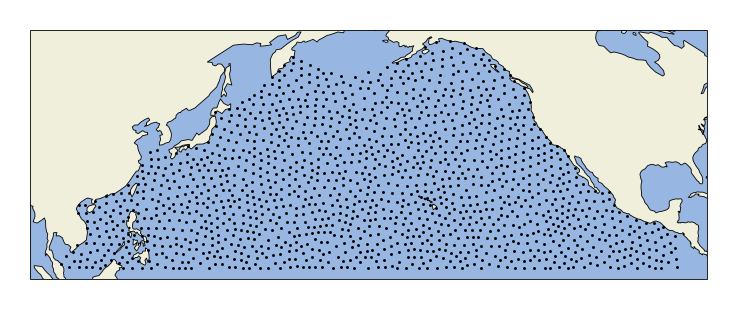

In [69]:
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson(central_longitude=180)
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


# Plot vertices 
alpha = 1.0
s = 0.5
marker = 'o'
zorder = 1
color='black'
lon = list(nx.get_node_attributes(G, 'longitude').values())
lat = list(nx.get_node_attributes(G, 'latitude').values())
scatter = ax.scatter(lon, lat, c=color, alpha=alpha, marker=marker, s=s, transform=ccrs.PlateCarree(), zorder=zorder, linewidths=0)


# Add land and ocean
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='none', alpha=1.0)
ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='none', alpha=1.0)
# ax.add_feature(cfeature.BORDERS, zorder=0, edgecolor='black', linewidth=0.2)

# save 
save_figure(fig, "vertices.pdf")

# 2. Plot subset of the simplicial complex

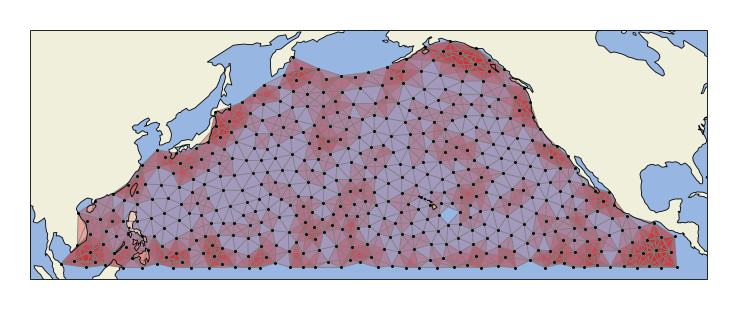

In [70]:
# Create the subgraph 
H = nx.subgraph(G, list(range(500)))


# figure 
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson(central_longitude=180)
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


# Plot the vertices 
alpha = 1.0
s = 0.5
marker = 'o'
zorder = 2
color='black'
node_to_lon = nx.get_node_attributes(H, 'longitude')
node_to_lat = nx.get_node_attributes(H, 'latitude')
lon, lat = list(node_to_lon.values()), list(node_to_lat.values())
scatter = ax.scatter(lon, lat, c=color, alpha=alpha, marker=marker, s=s, transform=ccrs.PlateCarree(), zorder=zorder, linewidths=0)


# edges 
color = 'tab:grey'
linewidth = 0.2
zorder = 1
alpha = 1.0

lines = []
for i, j in H.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]], [node_to_lon[j], node_to_lat[j]]])
lines = sanitize_lon_segments(lines, central=180.0, split=True)
lc = LineCollection(
    lines, 
    colors=color, 
    linewidths=linewidth, 
    zorder=zorder, 
    alpha=alpha, 
    transform=ccrs.PlateCarree(),
)
ax.add_collection(lc)


# triangles
zorder = 0
triangles = [
    (i, j, k) for i, j, k in sc2.triangles
    if i in H.nodes and j in H.nodes and k in H.nodes
]
polys = []
for (i, j, k) in triangles:
    polys.append([
        [node_to_lon[i], node_to_lat[i]], 
        [node_to_lon[j], node_to_lat[j]], 
        [node_to_lon[k], node_to_lat[k]]
    ])
polys = sanitize_lon_triangles(polys, central=180.0, split=False)
# constant face color
poly = PolyCollection(
    polys,
    facecolors='tab:red',
    edgecolors='tab:grey',
    linewidths=0.0,
    alpha=0.2,
    zorder=zorder,
    transform=ccrs.PlateCarree(),
)
ax.add_collection(poly)


# features 
ax.add_feature(cfeature.LAND, zorder=-1, edgecolor='none', alpha=1.0)
ax.add_feature(cfeature.OCEAN, zorder=-1, edgecolor='none', alpha=1.0)

# save 
save_figure(fig, "simplicial_subcomplex_on_500_vertices.pdf")


# 3. Plot data

### Construct Laplacian and Eigendecomposition

In [73]:
sc2.nodes

array([[   0],
       [   1],
       [   2],
       ...,
       [1497],
       [1498],
       [1499]], shape=(1500, 1))

In [124]:
import numpy as np
from scipy.sparse import diags, issparse
from typing import Iterable, Tuple
import numpy as np
from scipy.sparse import coo_matrix


def build_B1(sc2: "SimplicialComplexDim2"):
    """
    First boundary: nodes × edges, shape (n0, n1).
    Column e=(i->j): B1[i,e] = -1, B1[j,e] = +1.
    """
    # Nodes: assume iterable of ints; sort for stable indexing
    nodes = sorted(sc2.nodes)
    node_idx = {v[0]: k for k, v in enumerate(nodes)}

    # Edges: keep their given orientation (i, j)
    edges: list[Tuple[int, int]] = list(map(tuple, sc2.edges.tolist()))
    n0, n1 = len(nodes), len(edges)

    row, col, data = [], [], []

    for e_col, (i, j) in enumerate(edges):
        row.append(node_idx[i]); col.append(e_col); data.append(-1.0)
        row.append(node_idx[j]); col.append(e_col); data.append(+1.0)

    B1 = coo_matrix((data, (row, col)), shape=(n0, n1), dtype=float)
    return B1


def build_B2(sc2: "SimplicialComplexDim2"):
    """
    Second boundary: edges × triangles, shape (n1, n2).
    For each oriented triangle (i, j, k), use boundary (j,k) - (i,k) + (i,j).
    Entry B2[e, t] = ±1 if edge e is a face of triangle t, with sign agreeing
    with the relative orientation between e and the triangle boundary.
    """
    # Edges with their *stored* orientation must be consistent with B1
    edges: list[Tuple[int, int]] = list(map(tuple, sc2.edges.tolist()))
    n1 = len(edges)
    edge_idx = {e: k for k, e in enumerate(edges)}  # key uses stored orientation

    # Also map the undirected version to (index, sign) so we can match regardless of (u,v)/(v,u)
    undirected_to_index_sign = {}
    for k, (u, v) in enumerate(edges):
        if u <= v:
            undirected_to_index_sign[(u, v)] = (k, +1)   # stored orientation is (min,max)
            undirected_to_index_sign[(v, u)] = (k, -1)   # opposite
        else:
            undirected_to_index_sign[(v, u)] = (k, +1)
            undirected_to_index_sign[(u, v)] = (k, -1)

    triangles: list[Tuple[int, int, int]] = list(map(tuple, sc2.triangles.tolist()))
    n2 = len(triangles)

    row, col, data = [], [], []

    for t_col, (i, j, k) in enumerate(triangles):
        # Oriented boundary: (j,k) - (i,k) + (i,j)
        boundary_edges = [ (j, k, +1), (i, k, -1), (i, j, +1) ]
        for u, v, tri_sign in boundary_edges:
            # Find the column index of the edge in the *same orientation as stored in B1*
            try:
                e_row, edge_sign = undirected_to_index_sign[(u, v)]
            except KeyError:
                # If the complex didn't include this edge, skip (or raise).
                # Raising is usually safer so the complex stays a simplicial complex.
                raise KeyError(f"Edge ({u},{v}) from triangle ({i},{j},{k}) not found in edge list.")
            row.append(e_row)
            col.append(t_col)
            data.append(float(tri_sign * edge_sign))

    B2 = coo_matrix((data, (row, col)), shape=(n1, n2), dtype=float)
    return B2



def normalized_hodge_laplacian(B1, B2, return_symmetrized=False):
    """
    Normalized 1-Hodge Laplacian pieces for a 2D simplicial complex.

    Inputs
    ------
    B1 : (n0, n1) sparse   # nodes × edges
    B2 : (n1, n2) sparse   # edges × triangles
    return_symmetrized : bool
        If True, also return L1^s = D2^{-1/2} L1 D2^{1/2}.

    Outputs
    -------
    L_down : (n1, n1) sparse
        D2 * B1.T * D1^{-1} * B1
    L_up   : (n1, n1) sparse
        B2 * D3 * B2.T * D2^{-1}
    L1     : (n1, n1) sparse
        L_down + L_up
    (optional) L1_sym : (n1, n1) sparse
        D2^{-1/2} * L1 * D2^{1/2}
    """
    if not (issparse(B1) and issparse(B2)):
        raise TypeError("B1 and B2 must be scipy sparse matrices")

    B1 = B1.tocsr()
    B2 = B2.tocsr()
    n0, n1 = B1.shape
    n1b2, n2 = B2.shape
    if n1b2 != n1:
        raise ValueError(f"Shape mismatch: B1={(n0,n1)}, B2={(n1b2,n2)}; need B2 rows == B1 cols.")

    # --- D2 = max(diag(|B2| 1), I)  (edge degrees, at least 1)  ---  [Eq. (3.8)]
    absB2 = B2.copy(); absB2.data = np.abs(absB2.data)
    deg2 = np.asarray(absB2.sum(axis=1)).ravel().astype(float)   # per-edge "upper" degree
    deg2 = np.maximum(deg2, 1.0)                                 # ensure >= 1 so D2^{-1} is safe
    D2     = diags(deg2, format="csr")
    D2_inv = diags(1.0/deg2, format="csr")

    # --- D1 = 2 * diag(|B1| (D2 1))  (twice node weighted degrees)  ---  [Eq. (3.8)]
    absB1 = B1.copy(); absB1.data = np.abs(absB1.data)
    d1_vals = 2.0 * (absB1 @ deg2)                # length n0
    d1_vals = np.asarray(d1_vals).ravel().astype(float)
    # Invert safely: if a node is isolated (d1=0), set inverse weight to 0 (no contribution).
    d1_inv_vals = np.zeros_like(d1_vals)
    nz = d1_vals > 0
    d1_inv_vals[nz] = 1.0 / d1_vals[nz]
    D1_inv = diags(d1_inv_vals, format="csr")

    # --- D3 = (1/3) * I_{n2}  ---  [Eq. (3.8)]
    if n2 > 0:
        D3 = diags(np.full(n2, 1.0/3.0), format="csr")
    else:
        # No filled triangles -> upper term will be zero
        from scipy.sparse import csr_matrix
        D3 = csr_matrix((0, 0))

    # --- Pieces: L_down and L_up  ---  [Eq. (3.7)]
    L_down = D2 @ (B1.T @ (D1_inv @ B1))
    L_up   = (B2 @ (D3 @ B2.T)) @ D2_inv
    L1     = (L_down + L_up).tocsr()

    if return_symmetrized:
        # L1^s = D2^{-1/2} L1 D2^{1/2}   (used in normalized Hodge decomposition)  [Eq. (3.16)]
        D2_mhalf = diags(1.0/np.sqrt(deg2), format="csr")
        D2_phalf = diags(np.sqrt(deg2), format="csr")
        L1_sym = (D2_mhalf @ L1) @ D2_phalf
        return L_down.tocsr(), L_up.tocsr(), L1, L1_sym

    return L_down.tocsr(), L_up.tocsr(), L1


In [125]:
B1 = build_B1(sc2)
B2 = build_B2(sc2)

### Compute normalized Hodge Laplacian

In [186]:
L1_down, L1_up, L1 = normalized_hodge_laplacian(B1, B2)

### Compute the eigendecomposition of the Hodge Laplacian and partition it into grad, curl, harm components

In [127]:
import scipy


eigvals, eigvecs = scipy.sparse.linalg.eigsh(L1, k=500, which='SM')

In [ ]:
total_var = []
total_div = []
total_curl = []
num_eigemodes = len(eigvals)
for i in range(num_eigemodes):
    total_var.append(eigvecs[:, i].T @ L1 @ eigvecs[:, i])
    total_div.append(eigvecs[:, i].T @ L1_down @ eigvecs[:, i])
    total_curl.append(eigvecs[:, i].T @ L1_up @ eigvecs[:, i])
    
grad_eflow = np.where(np.array(total_div) >= 1e-3)[0]
curl_eflow = np.where(np.array(total_curl) >= 1e-2)[0]
harm_eflow = np.where(np.array(total_var) < 1e-6)[0]

In [177]:
    
grad_eflow = np.where(np.array(total_div) >= 1e-4)[0]
curl_eflow = np.where(np.array(total_curl) >= 1e-3)[0]
harm_eflow = np.where(np.array(total_var) < 1e-6)[0]

print(f"Found {len(grad_eflow)} grad eigemodes, {len(curl_eflow)} curl eigemodes, {len(harm_eflow)} harm eigemodes")

Found 88 grad eigemodes, 462 curl eigemodes, 0 harm eigemodes


In [187]:
import torch
torch.set_grad_enabled(False)


# tensor data type 
dtype = torch.float64

# convert the laplacians first to a list then to torch sparse csr tensors
L1 = torch.sparse_coo_tensor(L1.nonzero(), L1.data, L1.shape)
L1_down = torch.sparse_coo_tensor(L1_down.nonzero(), L1_down.data, L1_down.shape)
L1_up = torch.sparse_coo_tensor(L1_up.nonzero(), L1_up.data, L1_up.shape)

grad_evectors = torch.tensor(eigvecs[:, grad_eflow], dtype=dtype)
curl_evectors = torch.tensor(eigvecs[:, curl_eflow], dtype=dtype)
harm_evectors = torch.tensor(eigvecs[:, harm_eflow], dtype=dtype)
grad_evalues = torch.tensor(eigvals[grad_eflow], dtype=dtype)
curl_evalues = torch.tensor(eigvals[curl_eflow], dtype=dtype)
harm_evalues = torch.tensor(eigvals[harm_eflow], dtype=dtype)

### Create samples from the OceanGP

In [188]:
grad_vecs_masked = grad_evectors.mT
curl_vecs_masked = curl_evectors.mT
harm_vecs_masked = harm_evectors.mT
grad_vals_masked = grad_evalues
curl_vals_masked = curl_evalues
harm_vals_masked = harm_evalues


torch.save({
    'grad_vecs': grad_vecs_masked,
    'curl_vecs': curl_vecs_masked,
    'harm_vecs': harm_vecs_masked,
    'grad_vals': grad_vals_masked,
    'curl_vals': curl_vals_masked,
    'harm_vals': harm_vals_masked
}, 'ocean_hodge_basis-mine.pt')

In [189]:
from topofm.distributions import EdgeGP

payload = torch.load('ocean_hodge_basis-mine.pt')
init_gp_args = {
    'gp_type': 'diffusion',
    'harm_sigma': 1e-5,
    'grad_sigma': 11.808,
    'curl_sigma': 12.6,
    'harm_kappa': 0.0,
    'grad_kappa': 10.36,
    'curl_kappa': 9.53,
}

terminal_gp_args = {
    'gp_type': 'diffusion',
    'harm_sigma': 1e-5,
    'grad_sigma': 1.0,
    'curl_sigma': 1e-5,
    'harm_kappa': 0.0,
    'grad_kappa': 10.0,
    'curl_kappa': 0.0,
}

init_gp = EdgeGP(**payload, **init_gp_args)
terminal_gp = EdgeGP(**payload, **terminal_gp_args)

In [ ]:
x0 = init_gp.sample_euclidean(torch.Size([]))
x1 = terminal_gp.sample_euclidean(torch.Size([]))

### Greate edge vectors

In [191]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

edge_vectors = {}
for i, j in G.edges:
    lon_i, lat_i = G.nodes[i]["longitude"], G.nodes[i]["latitude"]
    lon_j, lat_j = G.nodes[j]["longitude"], G.nodes[j]["latitude"]

    x_i, y_i = transformer.transform(lon_i, lat_i)
    x_j, y_j = transformer.transform(lon_j, lat_j)

    u = x_j - x_i
    v = y_j - y_i

    edge_vectors[(i, j)] = (u, v)

### plot

# Other stuff

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

world_seas = gpd.read_file("./World_Seas_IHO_v3/World_Seas_IHO_v3.shp")

/tmp/ipykernel_39253/2404178027.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ocean_experiment_region = df.unary_union


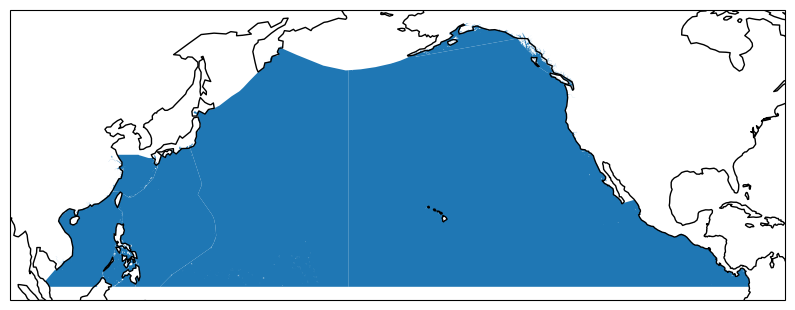

In [ ]:
from shapely.geometry import box


# Take only the following bodies of water
valid_names = [
    'North Pacific Ocean', 
    'Philippine Sea', 
    'China Sea', 
    'Sulu Sea', 
    'Gulf of Alaska', 
    'The Coastal Waters of Southeast Alaska and British Columbia',
    'South China Sea',
    'Celebes Sea',
    'Eastern China Sea',
]
df = world_seas.query("NAME in @valid_names")

# Cut everything below 5 degrees latitude
mask = gpd.GeoDataFrame(
    geometry=[box(-180, 5, 180, 90)], crs="EPSG:4326"
)
df = gpd.overlay(df, mask, how="intersection")


# Set up Cartopy plot
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(10, 6))
ax.coastlines()


# Plot polygons from geopandas
df.plot(ax=ax, transform=ccrs.PlateCarree())


#### Goal is to have a region to constrain the buoys to so that it matches the experiments 

In [22]:
ocean_experiment_region = df.dissolve()
ocean_experiment_region.to_file("region.gpkg", layer="region", driver="GPKG")

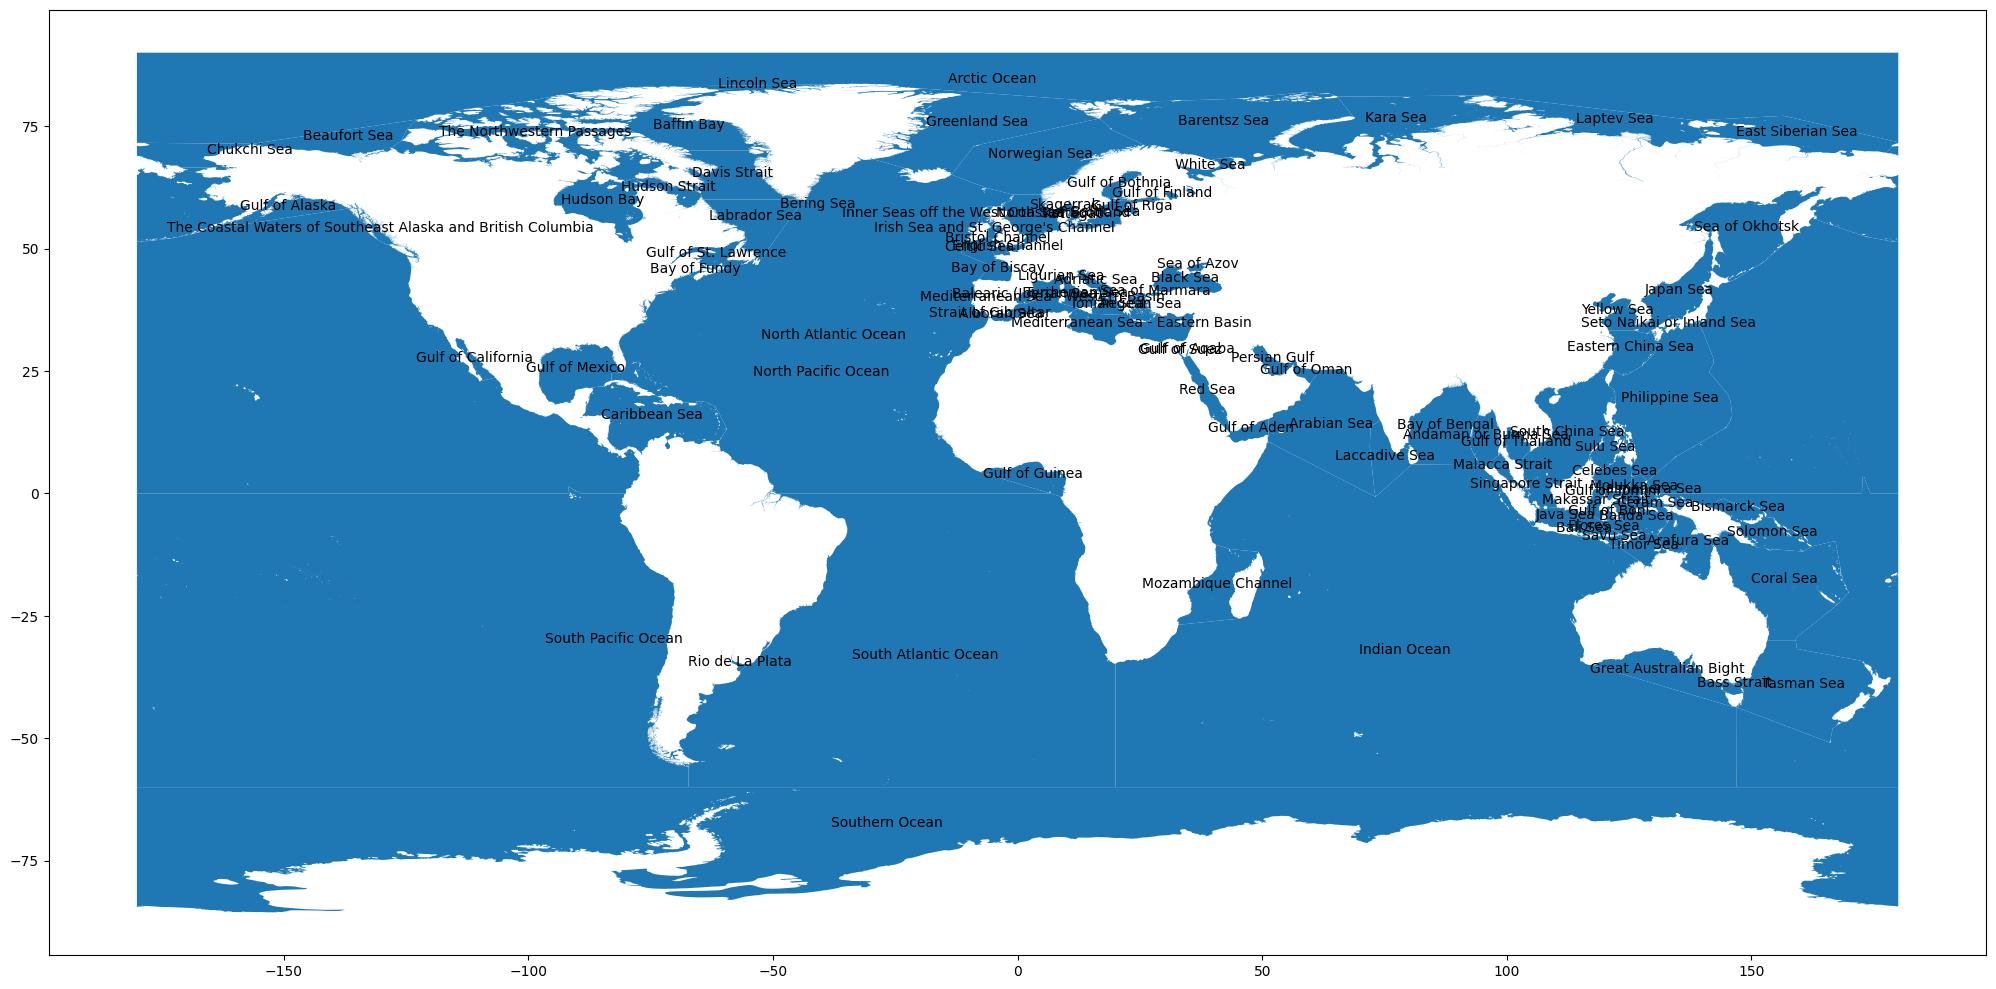

In [7]:
fig, ax = plt.subplots(figsize=(25, 25))
world_seas.plot(ax=ax)
world_seas.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);